# TP3: Perceptron multi-couche

En fin de séance, votre TP devra être déposé sur le dépot:
https://synapse.math.univ-toulouse.fr/s/xe7roT4HJckhogw

**Attention: Je n'accepte pas les TPs d'élèves absents en cours.**

Dans ce TP, nous revisitons le TP précédent dans une version plus sophistiquée. Par conséquent, nous utiliserons toujours le même dataset. Il s'agit du dataset public [Framingham](https://www.kaggle.com/amanajmera1/framingham-heart-study-dataset)
issu d'une étude en 1948 à Framingham, Massaschussets, USA et coordonnée par le U.S. Public Health Service. Je vous propose la version [ici](https://www.math.univ-toulouse.fr/~rchhaibi/teaching/2019/M1SID/framingham_fr.csv)
où j'ai simplement traduit les champs.

Description par le gouvernement américain: [Lien](https://biolincc.nhlbi.nih.gov/studies/framcohort/)
- Pour les variables binaires : “1”=“Oui”, “0”=“Non”.
- Pour les variables continues: Valeur intensive

Variable d'intérêt en dernière colonne:
Risque à 10 ans de développer une maladie coronaire (binaire)

* Facteurs démographiques:
  * Genre: Masculin ou Féminin (binaire: "1"=Masculin)
  * Age: Continu
  * Education: Niveau d'éducation 1,2,3,4
* Facteurs comportementaux:
  * Fumeur: (binaire)
  * CigsParJour: Cigarette par jour
* Facteurs médicaux historiques / Historique médical:
  * meds (binaire): si le patient est traité pour des problèmes de pression sanguine
  * avc  (binaire): si le patient a déjà fait un avc
  * hypertension (binaire): si le patient a de l'hypertension
  * diabete (binaire): si le patient est diabétique
* Facteurs médicaux courants:
  * Tot Chol: niveau de cholesterol total HDL + LDL + VLDL (Continu)
  * Sys BP: pression sanguine systolique (Continu)
  * Dia BP: pression sanguine diastolique (Continu)
  * IMC: Indice de Masse Corporelle (Continu)
  * freqCardiaque: Fréquence cardiaque (Continu)
  * Glucose: niveau de glucose (Continu)

In [1]:
# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

#Importation des données et nettoyage
dataframe=pd.read_csv("framingham_fr.csv")
dataframe.drop(['education'],axis=1,inplace=True)
dataframe.head()

#Counting the missing values and dropping them
count=0
for i in dataframe.isnull().sum(axis=1):
    if i>0:
        count=count+1
print("Le nombre total de lignes avec des valeurs manquantes est ", count)
print("Il s'agit de",round((count/len(dataframe.index))*100), '% du jeu de données.')
print("")
dataframe.dropna(axis=0,inplace=True)

#Ajout de la constante
from statsmodels.tools import add_constant as add_constant
dataframe = add_constant(dataframe)

# Statistiques descriptives
print("Statistiques descriptives:")
dataframe.describe()

Le nombre total de lignes avec des valeurs manquantes est  489
Il s'agit de 12 % du jeu de données.

Statistiques descriptives:


const     masculin          age       fumeur  cigsParJour  \
count  3749.0  3749.000000  3749.000000  3749.000000  3749.000000   
mean      1.0     0.445185    49.578821     0.488397     9.005335   
std       0.0     0.497053     8.569322     0.499932    11.922440   
min       1.0     0.000000    32.000000     0.000000     0.000000   
25%       1.0     0.000000    42.000000     0.000000     0.000000   
50%       1.0     0.000000    49.000000     0.000000     0.000000   
75%       1.0     1.000000    56.000000     1.000000    20.000000   
max       1.0     1.000000    70.000000     1.000000    70.000000   

              meds          avc  hypertension      diabete      totChol  \
count  3749.000000  3749.000000   3749.000000  3749.000000  3749.000000   
mean      0.030408     0.005601      0.311816     0.027207   236.952787   
std       0.171730     0.074643      0.463297     0.162709    44.610417   
min       0.000000     0.000000      0.000000     0.000000   113.000000   
25%       0.000000     0.000000      0.000000     0.000000   206.000000   
50%       0.000000     0.000000      0.000000     0.000000   234.000000   
75%       0.000000     0.000000      1.000000     0.000000   264.000000   
max       1.000000     1.000000      1.000000     1.000000   696.000000   

             sysBP        diaBP          IMC  freqCardiaque      glucose  \
count  3749.000000  3749.000000  3749.000000    3749.000000  3749.000000   
mean    132.365964    82.933716    25.809651      75.703921    81.883169   
std      22.051951    11.933321     4.065894      11.957763    23.888039   
min      83.500000    48.000000    15.540000      44.000000    40.000000   
25%     117.000000    75.000000    23.090000      68.000000    71.000000   
50%     128.000000    82.000000    25.410000      75.000000    78.000000   
75%     144.000000    90.000000    28.060000      82.000000    87.000000   
max     295.000000   142.500000    56.800000     143.000000   394.000000   

       risque10ans  
count  3749.000000  
mean      0.152574  
std       0.359624  
min       0.000000  
25%       0.000000  
50%       0.000000  
75%       0.000000  
max       1.000000

## I. Perceptron mono-couche = Regression logistique + Seuillage

Commençons par un peu de lecture:
https://fr.wikipedia.org/wiki/Perceptron

Comme indiqué sur le graphique, le perceptron est essentiellement un modèle linéaire composé avec une fonction de Heaviside. Ceci signifie que l'estimation est donnée par
$$ \widehat{Y} := H\left( \beta X \right)$$
où
- $Y \in \{0,1\}$ est la variable d'intérêt binaire
- $X \in \mathbb{R}^{k+1}$ est le vecteur des facteurs (avec intercept)
- $\beta \in \mathbb{R}^{k+1}$ est le vecteur des coefficients de régression
- $H(x) = \mathbb{1}_{\left\{x \geq 0\right\}}$ est la fonction de Heaviside

Maintenant souvenons nous de la régression logistique, vue la semaine dernière. 

### Ex 1:

En regression logistique, on a $Y = Bernoulli(p)$ avec  
$$ p = f(\beta X)$$
- (Cours) Pour quel $f$ avons cette égalité? Cette fonction est connue sous le nom de fonction logistique ou encore fonction sigmoïde.
- Faire un dessin de $x \mapsto f(x)$, puis de $x \mapsto f(10x)$.
- Que remarquez-vous? On calculera la limite:
$$ \lim_{\sigma \rightarrow \infty}
   \frac{1}{1+e^{-\sigma x}} \ .
$$

## Ex 2:
- Expliquer pourquoi fixer un niveau de treshold est équivalent à au perceptron mono-couche
- Compléter le code suivant pour donner une prédiction avec un seuillage pris dans le tableau "tresholds"
- On donnera, par des graphiques, une mesure de "accuracy" de la prédiction:
$$ \textrm{Accuracy}
   =
   \frac{\#\textrm{Cas prédits correctement}}
        {\#\textrm{Tous les cas}}
$$
la proportion de faux positifs et faux négatifs, ainsi que du score $F_1$ (cf https://en.wikipedia.org/wiki/F1_score)
- Donner visuellement un treshold optimal pour l'accuracy et le score $F_1$.

In [2]:
import statsmodels.api as sm

cols=dataframe.columns[:-1]
model=sm.Logit(dataframe.risque10ans,dataframe[cols])
result=model.fit()
result.summary()

Optimization terminated successfully.
         Current function value: 0.377199
         Iterations 7


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:            risque10ans   No. Observations:                 3749
Model:                          Logit   Df Residuals:                     3734
Method:                           MLE   Df Model:                           14
Date:                Thu, 12 Mar 2020   Pseudo R-squ.:                  0.1169
Time:                        06:13:50   Log-Likelihood:                -1414.1
converged:                       True   LL-Null:                       -1601.4
Covariance Type:            nonrobust   LLR p-value:                 2.922e-71
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const            -8.6463      0.687    -12.577      0.000      -9.994      -7.299
masculin          0.5740      0.107      5.343      0.000       0.363       0.785
age               0.0640      0.007      9.787      0.000       0.051       0.077
fumeur            0.0732      0.155      0.473      0.636      -0.230       0.376
cigsParJour       0.0184      0.006      3.003      0.003       0.006       0.030
meds              0.1446      0.232      0.622      0.534      -0.311       0.600
avc               0.7191      0.489      1.471      0.141      -0.239       1.677
hypertension      0.2146      0.136      1.574      0.116      -0.053       0.482
diabete           0.0025      0.312      0.008      0.994      -0.609       0.614
totChol           0.0022      0.001      2.074      0.038       0.000       0.004
sysBP             0.0153      0.004      4.080      0.000       0.008       0.023
diaBP            -0.0039      0.006     -0.619      0.536      -0.016       0.009
IMC               0.0103      0.013      0.820      0.412      -0.014       0.035
freqCardiaque    -0.0023      0.004     -0.550      0.583      -0.010       0.006
glucose           0.0076      0.002      3.408      0.001       0.003       0.012
=================================================================================
"""

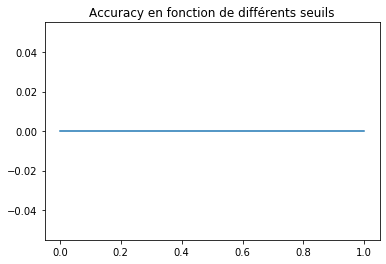

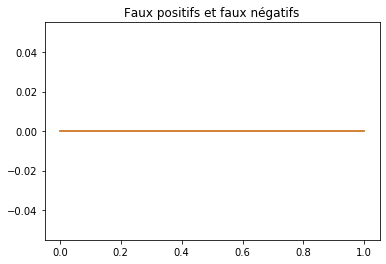

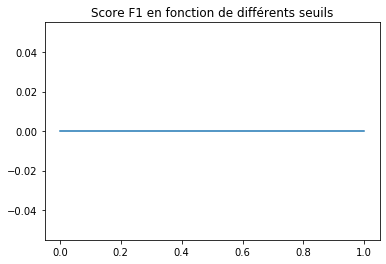

In [3]:
tresholds = np.linspace(0, 1, 100)
# Statsmodel for logistic regression
beta  = result.params
p_hat = result.predict()
Y     = dataframe["risque10ans"]
# Compute accuracy and F1
accuracy = np.zeros( len(tresholds) )
FP_array = np.zeros( len(tresholds) )
FN_array = np.zeros( len(tresholds) )
F1_score = np.zeros( len(tresholds) )
for i in range(len(tresholds)):
    alpha = 0
    # TODO
# Plots
plt.plot(tresholds, accuracy)
plt.title("Accuracy en fonction de différents seuils")
plt.show()
plt.plot(tresholds, FP_array)
plt.plot(tresholds, FN_array)
plt.title("Faux positifs et faux négatifs")
plt.show()
plt.plot(tresholds, F1_score)
plt.title("Score F1 en fonction de différents seuils")
plt.show()

## II. Perceptron multi-couches

Cette section a un objectif plutôt illustratif pour vous démontrer que les classifieurs binaires à base de réseaux de neurones ( = perceptron multicouches, https://en.wikipedia.org/wiki/Multilayer_perceptron) sont essentiellement des raffinements de la régression logistique.

Nous utiliserons essentiellement un framework moderne dénommé pyTorch:
https://pytorch.org/

La modélisation statistique est essentiellement identique à la régression logistique:
- Facteurs : $X$
- Variable d'intérêt binaire: $Y | X \stackrel{\mathcal{L}}{=} Bernoulli(p = N(X))

Cette fois-ci, N(X) n'est pas donné par une fonction de lien explicite mais donnée par un réseau de neurones.

### Ex 3: 
Les poids du réseau de neurones encodent la fonction et donc les paramètres sont $\theta$ et la fonction s'écrit $N_\theta(X)$.
- Ecrire la vraisemblance du modèle si nous observons $(x_1, y_1), \dots, (x_n, y_n)$.
- Décrire l'estimateur de maximum de vraisemblance. Est-ce que l'algorithme de Newton-Raphson vous semble applicable?

Réponse:
Pour la vraisemblance
$$
\begin{align*}
  & \log L(y, \theta)\\
= & \sum_{i=1}^n \log \mathbb{P}\left( Y_i = y_i | X_i = x_i \right) \\
= & \sum_{i=1}^n y_i \log \mathbb{P}\left( Y_i = 1 | X_i = x_i \right)
               + (1-y_i) \log \mathbb{P}\left( Y_i = 0 | X_i = x_i \right) \\
= & \sum_{i=1}^n y_i \log N_\theta(x_i)
           + (1-y_i) \log \left( 1 - N_\theta(x_i) \right) \ .
\end{align*}
$$
L'estimateur de maximum de vraisemblance est donc
$$ \widehat{\theta}_n
   =
   \textrm{Argmax}_{\theta} \frac{1}{n}
   \sum_{i=1}^n \left[
            y_i \log N_\theta(x_i)
          + (1-y_i) \log \left( 1 - N_\theta(x_i) \right)
   \right]
   \ .
$$
Il semble difficile d'appliquer l'algorithme de Newton-Raphson.

### Ex 4: 
Lire et comprendre le code suivant. On complètera le code nécessaire aux plots comme précédemment.

In [4]:
# Common imports
import numpy as np
import time

# pyTorch imports
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils import data


# Device configuration for GPU accceleration if available
if torch.cuda.is_available():
    device = torch.device('cuda:0')
else:
    device = torch.device('cpu')
print(device)

cuda:0


In [5]:
# Format dataset to numpy
X_train = np.array( dataframe[dataframe.columns[:-1]] )
Y_train = np.array( dataframe.risque10ans)
# Convert to torch tensors
X_train = torch.tensor( X_train ).float()
Y_train = torch.tensor( Y_train ).float()
# Create torch loaders
train_dataset    = data.TensorDataset(X_train, Y_train) # create your datset
train_dataloader = data.DataLoader(train_dataset, batch_size=256, shuffle=True)

In [6]:
input_dim  = X_train.shape[1]
layer_dim  = 5
output_dim = 1
print("Dimension d'entrée     : %d"%input_dim)
print("Dimension intermédiaire: %d"%layer_dim)
print("Dimension de sortie    : %d"%output_dim)

#Definition of a network
#
#  Input : X
#  Output: p = Perceptron(X) = N(X)
class PerceptronModule(nn.Module):
    def __init__(
            self,
            input_dim=input_dim,
            layer_dim=layer_dim,
            output_dim=output_dim,
    ):
        super(PerceptronModule, self).__init__()

        self.layer  = nn.Linear(input_dim, layer_dim)
        self.layer2 = nn.Linear(layer_dim, layer_dim)
        self.output = nn.Linear(layer_dim, output_dim)

    def forward(self, X, **kwargs):
        X = F.relu(self.layer (X))
        X = F.relu(self.layer2(X))
        X = self.output(X)
        X = torch.sigmoid(X)
        return X

Dimension d'entrée     : 15
Dimension intermédiaire: 5
Dimension de sortie    : 1


In [7]:
#Initialize the model        
model     = PerceptronModule()
print("Model :", model)
#Define loss criterion
criterion = nn.BCELoss(reduction="sum")
#Define the optimizer
optimizer = torch.optim.RMSprop(model.parameters(), lr=1e-4)

#Train
epochs = 100
losses = []
for epoch in range(epochs):
    start = time.time()
    model.train()
    #
    for i_batch, sample_batched in enumerate(train_dataloader):   
        X_batch, Y_batch = sample_batched
        # Forward
        p_output = model.forward(X_batch)
        loss     = criterion(p_output, Y_batch)
        # Back-propagate and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        losses.append(loss)
    # end for
    duree_epoch = time.time() - start

    print ('Epoch [{}/{}], Loss: {:.4f}, Duration: {:.1f} s' 
           .format(epoch+1, epochs, loss, duree_epoch))

Model : PerceptronModule(
  (layer): Linear(in_features=15, out_features=5, bias=True)
  (layer2): Linear(in_features=5, out_features=5, bias=True)
  (output): Linear(in_features=5, out_features=1, bias=True)
)
Epoch [1/100], Loss: 218.7129, Duration: 0.0 s
Epoch [2/100], Loss: 179.4964, Duration: 0.0 s
Epoch [3/100], Loss: 163.9724, Duration: 0.0 s
Epoch [4/100], Loss: 145.4778, Duration: 0.0 s
Epoch [5/100], Loss: 137.9382, Duration: 0.0 s
Epoch [6/100], Loss: 127.4999, Duration: 0.0 s
Epoch [7/100], Loss: 118.8675, Duration: 0.0 s
Epoch [8/100], Loss: 113.8462, Duration: 0.0 s
Epoch [9/100], Loss: 108.0292, Duration: 0.0 s
Epoch [10/100], Loss: 107.0060, Duration: 0.0 s
Epoch [11/100], Loss: 98.7612, Duration: 0.0 s
Epoch [12/100], Loss: 97.1106, Duration: 0.0 s
Epoch [13/100], Loss: 91.6377, Duration: 0.0 s
Epoch [14/100], Loss: 89.3059, Duration: 0.0 s
Epoch [15/100], Loss: 89.8242, Duration: 0.0 s
Epoch [16/100], Loss: 82.3173, Duration: 0.0 s
Epoch [17/100], Loss: 82.6270, Durat

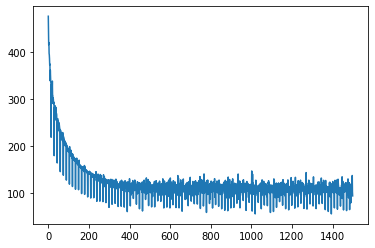

In [8]:
plt.plot(losses)

In [9]:
p_hat = model.forward(X_train).detach().cpu().numpy()
Y     = Y_train.detach().cpu().numpy()

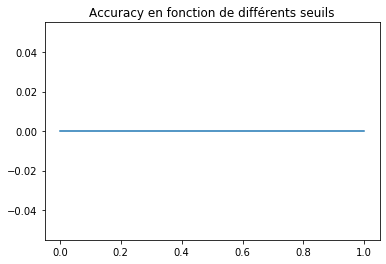

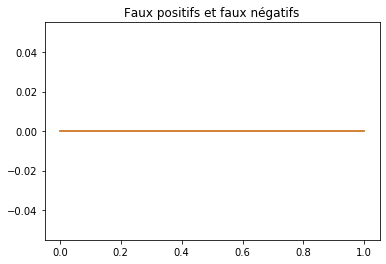

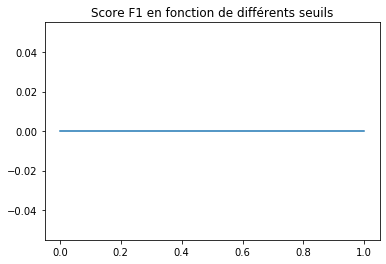

In [10]:
tresholds = np.linspace(0, 1, 100)
# Compute accuracy and F1
accuracy = np.zeros( len(tresholds) )
FP_array = np.zeros( len(tresholds) )
FN_array = np.zeros( len(tresholds) )
F1_score = np.zeros( len(tresholds) )
for i in range(len(tresholds)):
    alpha = 0
    # TODO
# Plots
plt.plot(tresholds, accuracy)
plt.title("Accuracy en fonction de différents seuils")
plt.show()
plt.plot(tresholds, FP_array)
plt.plot(tresholds, FN_array)
plt.title("Faux positifs et faux négatifs")
plt.show()
plt.plot(tresholds, F1_score)
plt.title("Score F1 en fonction de différents seuils")
plt.show()

## Conclusion:
Dans ce cas simple, le réseau de neurones à plusieurs couches
- donne des résultats similaires (voire le score F1 semble moins bon).
- est bien plus lent et difficile à entrainer.

La morale de l'histoire est que la régression logistique demeure la meilleure solution dans les cas d'école.